In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import cmocean
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import pyshtools
from scipy import interpolate as interp
from scipy.optimize import curve_fit as curve_fit


## 1. Inferring sea level from Pleistocene coral {-}

**The picture below shows a part of a fossil branch of an Acropora Palmata coral that was found in the Bahamas and dates to the Last Interglacial. The top of the coral was found at an elevation of 3.2m and the measurement precision of the GPS is 50cm. To investigate the indicative meaning, we can use data on the present living depth range of Acropora Palmata from the ocean biogeographic information system (OBIS). Show a histogram of the depths at which A. Palmata are found today using the provided data in the excel sheet. Use this data to calculate the relative water level and the indicative range for Acropora Palmata, which you can approximate as the mean and twice the standard deviation of this dataset. Using this information, estimate how high relative sea level (including uncertainty) was in the Bahamas during the Last Interglacial.**

In [3]:
AP_depths = pd.read_excel('AP_depth_range.xlsx', usecols=[0], skiprows=4)
AP_rwl = AP_depths.mean().item()
AP_ir = 2*AP_depths.std().item()
AP_depths

,A. palmata
0,0.55
1,0.55
2,0.55
3,0.55
4,0.55
...,...
4755,15.00
4756,16.40
4757,19.00
4758,22.00


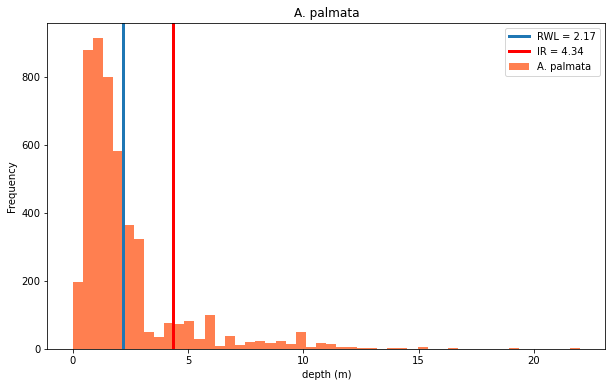

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
AP_depths.plot.hist(bins=50, ax=ax, color='coral',label='histogram')
ax.axvline(AP_rwl,lw=3,label=f'RWL = %.2f'%AP_rwl)
ax.axvline(AP_ir,lw=3,label=f'IR = %.2f'%AP_ir, c='r')
ax.set_title('A. palmata')
ax.set_xlabel('depth (m)')
ax.legend();

In [5]:
rsl = 3.2 - (-1*AP_rwl)
sigma_rsl = np.sqrt((0.5)**2 + (AP_ir/2)**2)
print(f'RSL = %.2f' %rsl)
print(f'sigma_RSL = %.2f' %sigma_rsl)

RSL = 5.37
sigma_RSL = 2.23


We get a relative sea level of 5.37 m with an uncertainty of 2.23 m.

## 2. $\delta^{18}$O balance {-}
**Use the oxygen isotope approach to estimate how much lower global mean sea level was during the last glacial maximum (LGM) compared to today. To estimate this you will need the values from the table below, the values from the Lisiecki and Raymo (2005) benthic oxygen stack (the first figure in lecture 10) and the equations we have used in class (during the breakout groups). Given that the Laurentide and Fennoscandian ice sheets were at a similar latitude than the present-day Greenland ice sheet, you can assume that excess ice during the LGM had the same d18O as the Greenland ice sheet does today.**

**Global mean sea level was around 120 – 130m lower during the last glacial maximum than it is today. How does this compare to your result and what are reasons for it to maybe differ?**
![2](PSet_2_2.png)
![](benthic_stack.png)

First we have our mass conservation equation:

$M_{ocean}(today) = M_{ocean}(LGM) + M_{ice}(LGM)$

and our isotopic ratio conservation:

$M_{ocean}(today)\cdot \delta^{18}O_{ocean}(today) = M_{ocean}(LGM)\cdot \delta^{18}O_{ocean}(LGM) + M_{ice}(LGM)\cdot \delta^{18}O_{ice}(LGM)$

If we substitute into the isotope equation $M_{ocean}(LGM) = M_{ocean}(today) - M_{ice}(LGM)$, we get:

$M_{ocean}(today)\cdot \delta^{18}O_{ocean}(today) = (M_{ocean}(today) - M_{ice}(LGM))\cdot \delta^{18}O_{ocean}(LGM) + M_{ice}(LGM)\cdot \delta^{18}O_{ice}(LGM)$

and then plug in values from the table and  solve for mass of ice excess in LGM, using $\delta^{18}O_{ocean}(LGM)=5\%$ from the figure above:

$(1358e18)\cdot3.2 = (1358e18-M_{ice}(LGM))\cdot5 + M_{ice}(LGM)\cdot(-35)$

$M_{ice}(LGM) \approx 61e18 \textrm{ kg}$

Now if we assume that the the sea level rise from the excess ice in the LGM scales like the Greenland Ice Sheet, we would get 7.3 m of sea level rise per $2.66e18$ kg of ice melt. We multiply the mass of excess ice in the LGM by this ratio to get how much lower sea level was during the LGM:

$\Delta SL = 61e18 \textrm{ kg} \cdot \frac{7.3 \textrm{ m}}{2.66e18 \textrm{ m}} \approx 168 m$

So according to this approximation, sea level was about **168 m lower** during the LGM. These results could differ from the 120-130 m because we assumed that the $\delta^{18}$O of all the excess LGM ice was exactly that of the Greenland Ice Sheet, which might not necessarily be true, because the $\delta^{18}$O could differ slightly even though the Laurentide and Fennoscandian ice sheets were at similar latitudes as Greenland, and there could also have been an Antartctic contribution with a lower $\delta^{18}$O. Also, the $\delta^{18}$O proxy is dependent on temperature, elevation, the shape of ice sheets, and precipitation patterns, all of which have uncertainties that could contribute to the excess ice having a different $\delta^{18}$O than what we used in our calculation. 

# 3. Using spherical harmonics {-}

**Use spherical harmonics to calculate the mean ocean depth. To do that, follow these steps:**

**a) Load the topography provided for problem set 1 (etopo_15_ice) and construct the
ocean function, which is defined as C(lon,lat) = 1 in the oceans and C(lon,lat) = 0 on
land. Submit a figure showing a map of your ocean function.**

In [47]:
# read in with pandas, pivot into xarray dataarray
df = pd.read_csv('etopo_ice_15.txt', delim_whitespace=True, header = 0, usecols=[0,1,2],names = ['lon', 'lat', 'z'])
df_pv = df.pivot(index="lat", columns="lon")
df_pv.columns = df_pv.columns.droplevel(0)
da = xr.DataArray(data=df_pv).rename('z')

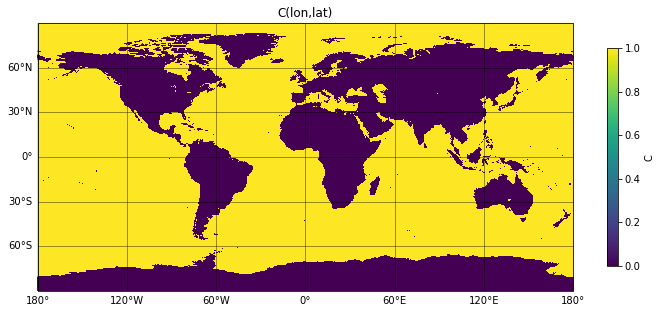

In [48]:
# define ocean function & plot
C = (da<0).astype(int)

plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, color='k', alpha = 0.5)
gl.top_labels = False
gl.right_labels = False
C.plot(ax=ax, transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.5,'label':'C'})
ax.set_title('C(lon,lat)');


**b) Calculate the global average value of the ocean function using spherical harmonics.
What does this number represent? Consider whether you need to interpolate your ocean function onto a Gauss Legendre grid before doing the spherical harmonic transform.**

In [49]:
# make GLQ grid from ocean function dataarray (C)
shgrid = pyshtools.SHGrid.from_xarray(C,grid='GLQ')
lmax = shgrid.lmax

# expand into spherical harmonic coefficients (i looked thru the default arguments, all seem correct)
clm = shgrid.expand()

# inverse transform with only degree l=0, convert the grid back to dataarray
sh_l0 = clm.expand(grid='GLQ',lmax=lmax,lmax_calc=0).to_xarray()

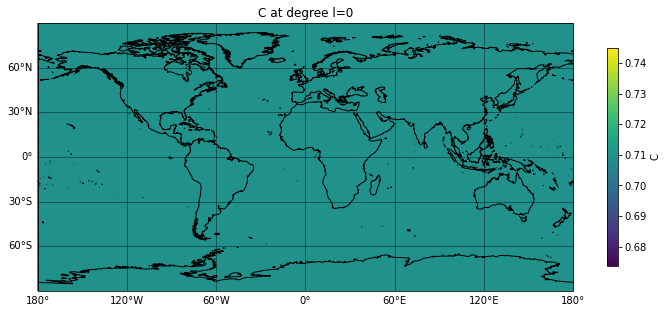

In [52]:
plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
gl = ax.gridlines(draw_labels=True, color='k', alpha = 0.5)
gl.top_labels = False
gl.right_labels = False
sh_l0.plot(ax=ax, transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.5,'label':'C'})
ax.set_title('C at degree l=0');

In [51]:
print(f'The global average value of C is %.2f.'%sh_l0.mean().item())

The global average value of C is 0.71.


This represents the percentage (71%) of the earth's surface that is covered in ocean.

**c) Calculate the mean ocean depth using spherical harmonics. To do so construct a new field that is equal to topography but 0 on land. Calculate the global average of this field and then use your result from (b) to account for the fact that you don’t actually want the global average, but only the average in the ocean basins.**

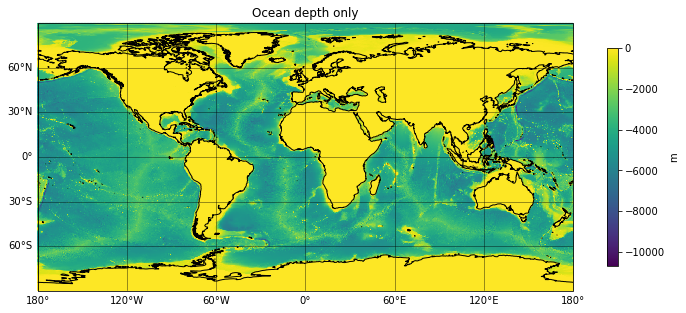

In [53]:
# new topo da that is 0 on land
da_bathy = da.where(da<0,other=0)

# plot it to make sure
plt.figure(figsize=(12,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
gl = ax.gridlines(draw_labels=True, color='k', alpha = 0.5)
gl.top_labels = False
gl.right_labels = False
da_bathy.plot(ax=ax, transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.5,'label':'m'})
ax.set_title('Ocean depth only');

In [54]:
# make GLQ grid from ocean function dataarray (C)
shgrid = pyshtools.SHGrid.from_xarray(da_bathy,grid='GLQ')
lmax = shgrid.lmax

# expand into spherical harmonic coefficients
clm = shgrid.expand()

# inverse transform with only degree l=0, convert the grid back to dataarray
sh_ocean_l0 = clm.expand(grid='GLQ',lmax=lmax,lmax_calc=0).to_xarray()

In [55]:
# divide by the % ocean to get true mean ocean depth
print(f'The global average value of the ocean depth is %.0f m.'%(-1*sh_ocean_l0.mean().item()/sh_l0.mean().item()))

The global average value of the ocean depth is 3687 m.


# 4. Earth’s viscosity {-}
**A relative sea level curve for Richmond Gulf, Hudson Bay, has been established on the basis of the dating of shell specimens. The age-height pairs for these samples are listed below.**

**a) Determine the post-glacial decay time of Richmond Gulf using these data. Your answer should include a plot showing the data points and your best fitting curve. In addition to the data provided, consider that you also know the current relative sea level.**

In [12]:
# read in ages & zs, and add (0,0) for current sea level
ages = np.array([0,6000, 6230, 6430, 1790, 2030, 2760, 3360])
zs = np.array([0,137, 154, 172, 22, 29, 44, 58])

# first i force the fit to be very close to the point (0,0)
# by setting the relative error (sigma, stdev) to be high for all of the points and low for (0,0)
y_weight = 10*np.ones_like(zs)
y_weight[0] = 1

# then use scipy curve_fit to fit to exponential with an initial guess p0 and weights as above
params, covs = curve_fit(lambda x,a,b,c: a*np.exp(b*x)+c, ages,  zs,  p0=(1, 0.001,0),  sigma = y_weight)

# use the params we found above to create a plottable line of best fit
x = np.arange(0,6430,20)
y = params[0]*np.exp(params[1]*x) + params[2]

# tau
tau = 1/params[1] # years

In [43]:
# use the params we found above to create a plottable line of best fit
x = np.arange(0,6430,20)
y = params[0]*np.exp(params[1]*x) + params[2]

# tau
tau = 1/params[1] # years

The post-glacial decay time is tau=4167 years.


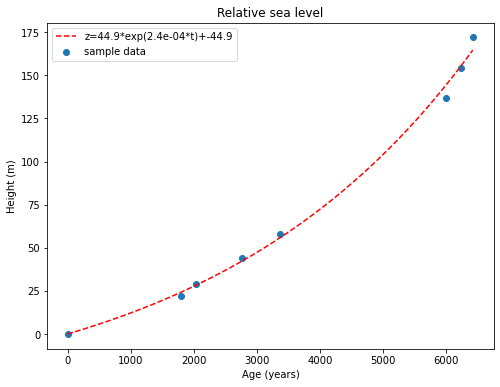

In [44]:
# plot the data and best fit curve
plt.figure(figsize=(8,6))
plt.scatter(ages,zs,label='sample data')
plt.plot(x,y,'--r',label=f'z=%.1f*exp(%.1e*t)+%.1f'%tuple(params))
plt.legend()
plt.xlabel('Age (years)')
plt.ylabel('Height (m)')
plt.title('Relative sea level')

print(f'The post-glacial decay time is tau=%.0f years.'%tau)

**b) Using this decay time estimate the average mantle viscosity below Canada. You can assume the following values: Young’s modulus of 1011 N/m2, mantle density 3000 kg/m3, depth of compensation L = 1200km. Over what depth in the mantle does this average apply?**

In [42]:
# tau in seconds
tau_s = tau * 31556952 # seconds 

# young's modulus
k = 1e11 # N/m2

# mantle density
rho_m = 3000 # kg/m3

# depth of compensation 
L = 1200*1000 # 1200 km to m

# g
g = 9.8 # m/s2

# alpha
alpha = k + rho_m*g*L

In [56]:
# mantle viscosity
eta = tau_s*g*rho_m*k*L / alpha
print(f'The average mantle viscosity is nu=%.2e Pa s.'%eta)

The average mantle viscosity is nu=3.43e+21 Pa s.


This viscosity applies about over the depth of compensation, 1200km.

# 5. Earth’ Maxwell time {-}

**a) What is the response (strain as a function of time) of a Maxwell viscoelastic material to the application of a constant stress $\sigma_0$? To answer this question it might help to first think about what the strain is at time t = 0 and then solve the constitutive equation with this initial condition and assuming constant stress $\sigma_0$.**



The constitutive equation is:
$$
\dot e = \frac{\dot \sigma}{\kappa} + \frac{\sigma}{\eta}.
$$

When stress is constant, $\sigma = \sigma_0$ and $\dot \sigma = 0$. So our constitutive equation becomes:

$$
\dot e = \frac{\sigma_0}{\eta}.
$$

So the time derivative of strain is constant. We can integrate this to get

$$
e(t) = \frac{\sigma_0}{\eta}t + e(t=0).
$$

Since we know that the elastic component of strain reacts instantaneously, $e(t=0) = \frac{\sigma_0}{\kappa}$ so the response of strain is

$$
e(t) = \frac{\sigma_0}{\eta}t + \frac{\sigma_0}{\kappa}.
$$

**b) Draw a diagram of strain (y axis) as a function of time (x axis) and mark the elastic portion and the viscous portion.**

![5](PSet_2_5b.png)


**c) Identify the elastic and viscous strains as a function of time, and provide an equation for the time tM at which these two are equal. What is the physical meaning of this time? Estimate this value for the Earth assuming a Young’s modulus of 1011 N/m2 and a viscosity of 1021 Pa*s.**

The constant elastic component of the strain is
$$
e_{elastic} = \frac{\sigma_0}{\kappa}
$$
and the linear viscous component of the strain is
$$
e_{viscous} = \frac{\sigma_0}{\eta}t.
$$
These are equal at $t_m$ when 
$$
\frac{\sigma_0}{\kappa} = \frac{\sigma_0}{\eta}t_M
$$
or
$$
t_M = \frac{\eta}{\kappa}.
$$

Using $\kappa=10^{11}$ N/m$^2$ and $\eta=10^{21}$ Pa*s, we get a Maxwell time of $t_M = 10^{10}$ seconds which is on the order of $10^2$ years. This represents the time when half of the deformation is due to the viscous strain and half is due to the elastic strain, or when the viscous deformation catches up to the instantaneous elastic deformation.